# Introduction
In this exercise, a Time Series Analysis (TSA) will be performed. This will be done using the Retail Data Analytics data from Kaggle: https://www.kaggle.com/manjeetsingh/retaildataset 

This contains three different csv files that will be merged together.

In [1]:
# Import the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
# Read the datasets
features = pd.read_csv("Features data set.csv", parse_dates = ['Date'])
sales = pd.read_csv("sales data-set.csv", parse_dates = ['Date'])
stores = pd.read_csv("stores data-set.csv")

display(features.head())
display(sales.head())
display(stores.head())

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Merge the datasets
In this paragraph, the datasets will be merged into one. This will be done, using the following three features:
- `Store`
- `Date`
- `IsHoliday`

NOTE: feature `IsHoliday` will be used as key to prevent unnecessary extra features.

In [3]:
df = pd.merge(features, sales, on = ['Store', 'Date', 'IsHoliday'], suffixes = ('_features', '_sales'))
df = pd.merge(df, stores, on = 'Store')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     150681 non-null  float64       
 5   MarkDown2     111248 non-null  float64       
 6   MarkDown3     137091 non-null  float64       
 7   MarkDown4     134967 non-null  float64       
 8   MarkDown5     151432 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday     421570 non-null  bool          
 12  Dept          421570 non-null  int64         
 13  Weekly_Sales  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

## Clean the data
In this paragraph, the data will be cleaned. This will be done by doing the following steps:
- Deal with null values
- Deal with outliers

### Deal with null values
Based on the info method before, we can see that the Markdown1 to Markdown5 columns have a lot of null values. We'll check the correlation matrix to see if they have any linear relations with other features.

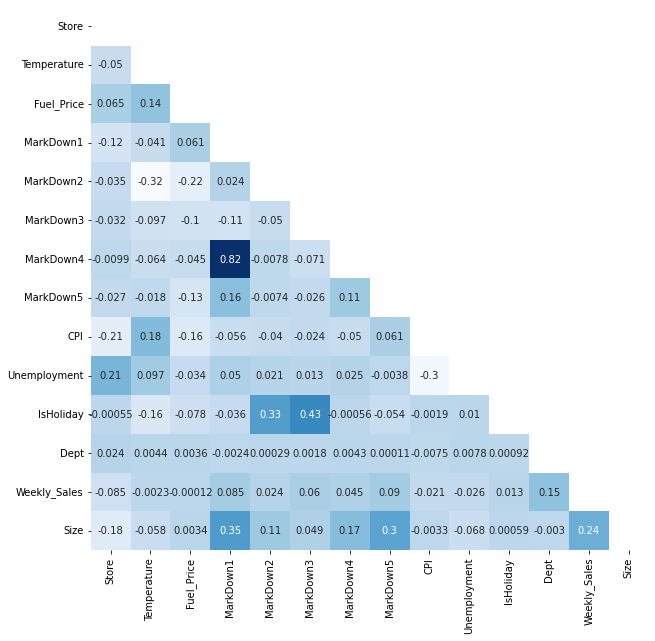

In [4]:
# Create correlation matrix
corr = df.corr()

fig, ax = plt.subplots(figsize = (10, 10))

# Create mask to only show lower half of correlation matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, cbar = False, 
            cmap = 'Blues', ax = ax, mask = mask)
plt.show()

#### Findings
Based on our analysis, we can see that there're only a few linear relationships the Markdown column have with the other features. And since that there're a lot of missing values, the column will be removed from the dataset.

In [5]:
# Remove MarkDown columns
cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

df = df.drop(cols, axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   CPI           421570 non-null  float64       
 5   Unemployment  421570 non-null  float64       
 6   IsHoliday     421570 non-null  bool          
 7   Dept          421570 non-null  int64         
 8   Weekly_Sales  421570 non-null  float64       
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 35.8+ MB


### Dealing with outliers
In this section, we're going to deal with outliers. The following columns could have outliers:
- Temperature
- Fuel price
- CPI
- Unemployment
- Weekly_sales
- Size

In order to check them, we'll the describe method and draw a boxplot for each column

In [6]:
df.describe()

,Store,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,60.090059,3.361027,171.201947,7.960289,44.260317,15981.258123,136727.915739
std,12.785297,18.447931,0.458515,39.159276,1.863296,30.492054,22711.183519,60980.583328
min,1.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,-4988.940000,34875.000000
25%,11.000000,46.680000,2.933000,132.022667,6.891000,18.000000,2079.650000,93638.000000
50%,22.000000,62.090000,3.452000,182.318780,7.866000,37.000000,7612.030000,140167.000000
75%,33.000000,74.280000,3.738000,212.416993,8.572000,74.000000,20205.852500,202505.000000
max,45.000000,100.140000,4.468000,227.232807,14.313000,99.000000,693099.360000,219622.000000


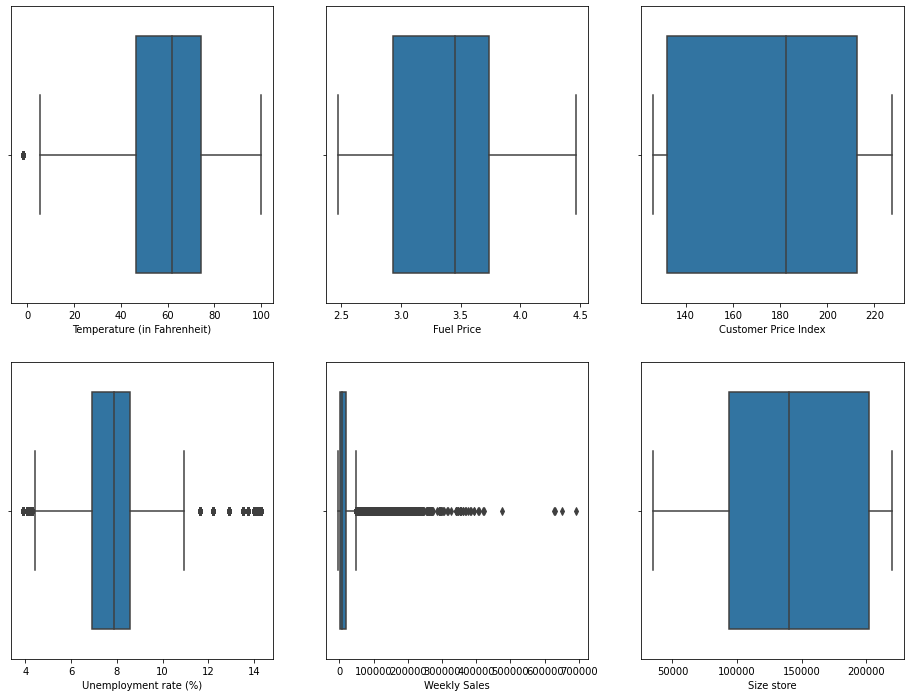

In [7]:
# Create subplots of distributions plot using a histogram
# Set parameters
cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Size']
labels = ["Temperature (in Fahrenheit)", 'Fuel Price', 'Customer Price Index',
         'Unemployment rate (%)', 'Weekly Sales', 'Size store']

# Draw box plot for each column
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (16, 12))

for col, label, ax in zip(cols, labels, axes.flat):
    sns.boxplot(x = col, data = df, ax = ax)
    ax.set_xlabel(label)
plt.show()

### Findings
Based on our analysis, we can see that the Weekly Sales is not really well distributed. Also, some values have a negative weekly sales. This is odd, since the weekly sales indicates the amount of stuff sold in a week. That's why the rows that have a negative value for weekly sales will be removed. In order to combat the distribution problem, we'll normalise the values of the numeric columns when we're going to train our model.

In [8]:
# Remove rows with a negative weekly sales value
df = df[df['Weekly_Sales'] >= 0]

print(f"The amount of negative weekly sales values: {sum(df['Weekly_Sales'] < 0)}")

The amount of negative weekly sales values: 0


# Data exploration and visualizations
In this chapter, we'll explore the data using visualizations. We'll plot the following visualizations
- Sales to check for seasonality (by multiple periods)
- Sales compared to temperatures
- Sales compared to unemployment rate
- Sales compared to fuel price
- Average sales for holidays vs non-holidays

These visualizations are chosen in order to check for interesting findings and to check for seasonality

## Seasonality sales

In [9]:
# Create function to compare the sales with a particular column in the dataset.
def sales(data, x, xcolumn, digits, ylabel, title):
    fig, ax = plt.subplots(figsize = (8, 6))
    # Copy the data
    df_copy = data.copy()
    # Round the numbers of x and set it in a new column of data
    df_copy[xcolumn] = np.round(data[x], digits)
    grouped = df_copy.groupby(xcolumn)['Weekly_Sales'].mean()
    grouped.plot()
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
# Create function to plot the sales per given period
def salesperiod(data, period, ax, title):
    # Set index to the datetime column
    data = data.resample(period, on = 'Date').size().reset_index(name='Count')
    
    sns.lineplot(data = data, x = 'Date',  y = 'Count', ax = ax, label = "Sales")
    ax.legend()
    ax.set_title(title)

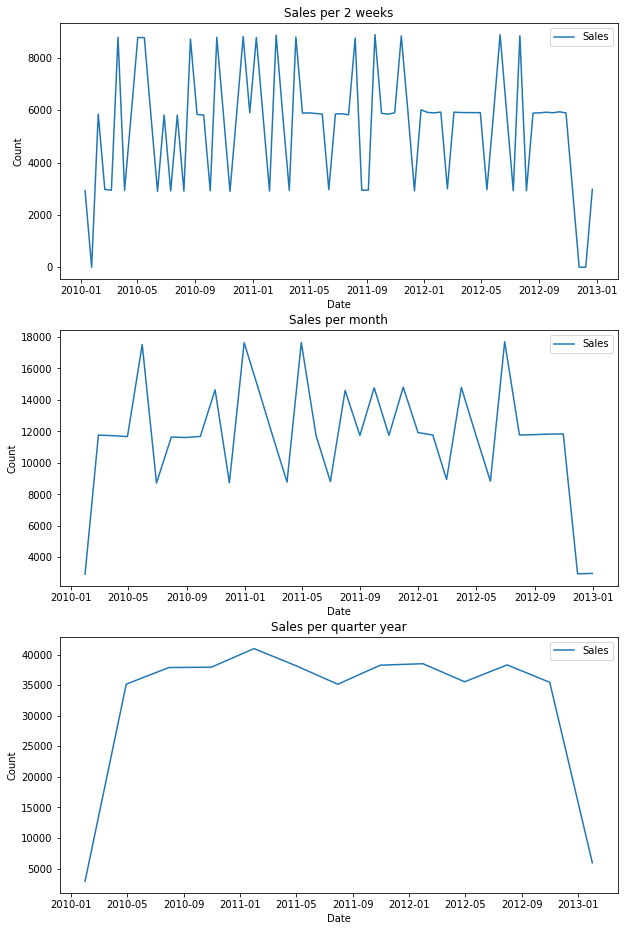

In [10]:
fig, axes = plt.subplots(figsize=(10, 16), nrows = 3)
# Set up list to loop over through
titles = ["Sales per 2 weeks", "Sales per month", "Sales per quarter year"]
periods = ["2W", "M", "3M"]

# Plot a line plot for each chosen period: biweekly, monthly, quarterly
for ax, title, period in zip(axes.flat, titles, periods):
    salesperiod(df, period, ax, title)

plt.show()

### Findings
Based on our analysis, it looks like that there's some seasonality around the holidays in America. The most common holidays are:
- Christmas and New Years eve
- Valentinesday
- Easter
- 4th of July (Independence day)
- Halloween

## Sales compared to temperatures


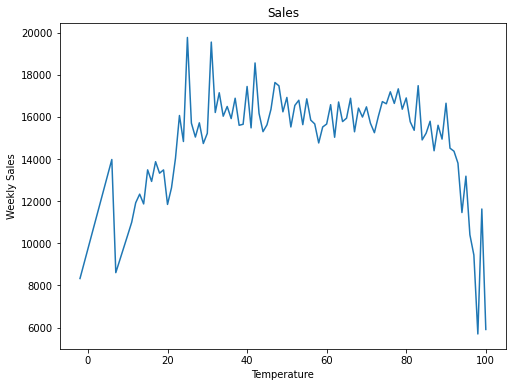

In [11]:
# Call the sales function to compare the average sales per temperature (rounded by 0)
sales(df, "Temperature", 'Temperature_rounded', 0, 'Weekly Sales', "Sales")

### Findings
It looks like the sales are quite low aroun the extreme temperatures (lower than 20 degrees or above 90). In between it looks like they're a bit higher and flunctuate less.

## Sales compared to unemployment rate


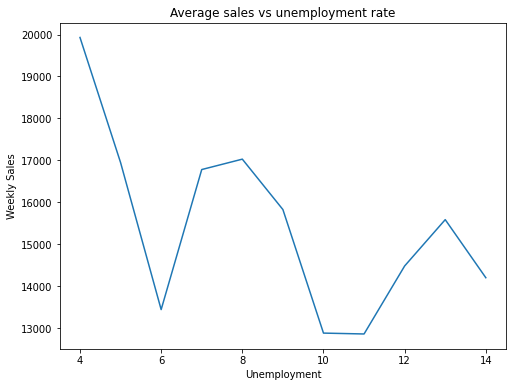

In [12]:
# Call the sales function to compare the average sales per unemployment rate percentage
# (rounded by 0)
sales(df, "Unemployment", 'Unemployment_rounded', 0, 'Weekly Sales', "Average sales vs unemployment rate")

### Findings
Although the sales go lower as the Unemployment progresses, there're still some higher sales for higher unemployment rates, e.g. 7 and 8 are higher than 6. The lowest, 4, does have the highest average sales though.

## Sales compared to fuel price


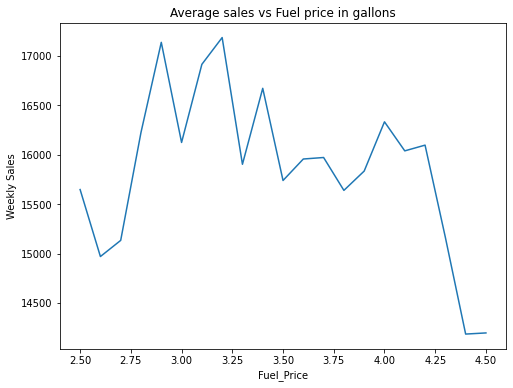

In [13]:
# Call the sales function to compare the average sales per fuel price per gallon (rounded by 1)
sales(df, "Fuel_Price", 'Fuel_Price_Rounded', 1, 'Weekly Sales', "Average sales vs Fuel price in gallons")

### Findings
Based on our analysis, it looks like the sale prices actually flunctuate a bit more when the prices go up after $ 2.75. 

We see a sharp drop after $ 4.25. It looks like that after that, it's harder for people to spend money on shopping.

## Average sales for holidays vs non-holidays

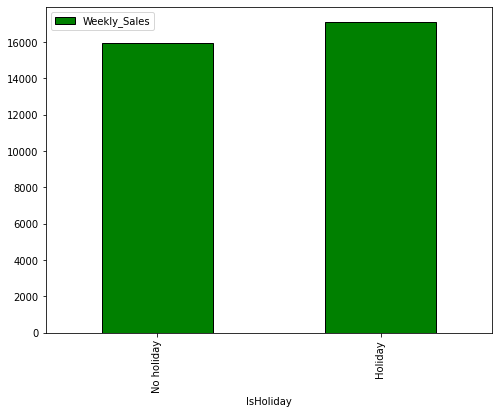

In [14]:
# Group by IsHoliday and get average weekly sales
data = df.groupby('IsHoliday')['Weekly_Sales'].mean()

fig, ax = plt.subplots(figsize = (8, 6))
data.plot.bar(ax = ax, color = 'green', edgecolor = 'black')
ax.set_xticklabels(labels = ['No holiday', 'Holiday'])
ax.legend()
plt.show()

### Findings
Based on our analysis, the average sales is higher for when it's a holiday. It looks like people will spend more money than.

# Model training and predicting
In this chapter, the model will be trained and predict. It will first predict on the test data and then on the future. We'll predict on the test data first, so that we can evaluate on that and give our recommendations with more confidence.


## Selecting store and department

In [15]:
# Select the store with the highest size and select department 1
df = df.loc[(df.Size == max(df.Size)) & (df.Dept == 1), :].reset_index(drop = True)

# Drop the columns Store, Type and Dept because they're constant variables
cols = ['Store', 'Type', 'Dept']
df = df.drop(cols, axis = 1)
df.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales,Size
0,2010-05-02,31.53,2.666,126.442065,8.316,False,46761.90,219622
1,2010-12-02,33.16,2.671,126.496258,8.316,True,78415.94,219622
2,2010-02-19,35.70,2.654,126.526286,8.316,False,44042.19,219622
3,2010-02-26,29.98,2.667,126.552286,8.316,False,31574.04,219622
4,2010-05-03,40.65,2.681,126.578286,8.316,False,34505.07,219622


## Scale the data
In this paragraph, the scaling of the data will be done. This will be done for the following columns:
- `Temperature`
- `Fuel_Price`
- `CPI`
- `Unemployment`
- `Weekly_Sales`
- `Size`

In [16]:
# Select columns to scale the data
cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Size']

# Instantiate Scaler
scaler = StandardScaler()

# Create copy of df and scale the columns of that copy: df_scaled
df_scaled = df.copy()
df_scaled[cols] = scaler.fit_transform(df_scaled[cols])
df_scaled.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales,Size
0,2010-05-02,-1.264570,-1.584628,-1.208346,1.496078,False,-0.009251,0.0
1,2010-12-02,-1.171583,-1.571852,-1.179081,1.496078,True,1.123275,0.0
2,2010-02-19,-1.026683,-1.615291,-1.162865,1.496078,False,-0.106557,0.0
3,2010-02-26,-1.352993,-1.582073,-1.148825,1.496078,False,-0.552646,0.0
4,2010-05-03,-0.744301,-1.546300,-1.134785,1.496078,False,-0.447779,0.0


## Model training and predicting

In [17]:
# Define train and test set
train = df_scaled.loc[df_scaled.Date < "2012-07-10", :].sort_values('Date').set_index('Date')
test = df_scaled.loc[df_scaled.Date >= "2012-07-10", :].sort_values('Date').set_index('Date')

# Split the train and test set into features and target
X_train = train.drop('Weekly_Sales', axis = 1)
y_train = train.loc[:, 'Weekly_Sales']
X_test = test.drop('Weekly_Sales', axis = 1)
y_test = test.loc[:, 'Weekly_Sales']

y_train.head()

Date
2010-01-10   -0.397833
2010-02-04    3.322026
2010-02-07   -0.467010
2010-02-19   -0.106557
2010-02-26   -0.552646
Name: Weekly_Sales, dtype: float64

In [18]:
# Define a function to plot the train set, test set and prediction
# using line plots and fill between: plot_prediction
# NOTE: set the parameter index default as test.index
# this will be changed for the predictions in the future
def plot_prediction(xlim, pred_lower, 
                    pred_upper, prediction, index = test.index):
    # Define figure and axes
    fig, ax = plt.subplots(figsize = (16, 12))
    
    # Set parameters
    x1, x2 = train.index, test.index
    y1, y2 = train['Weekly_Sales'], test['Weekly_Sales']
    labels = ["Train", "Test", "Prediction", "Range of prediction"]
    title = "Sales per week"
    xlabel = "Date"
    ylabel = "Weekly Sales (scaled)"
    
    # Define yticklabels to match original values instead of scaled ones
    yticklabels = np.arange(0, int(max(df.Weekly_Sales)), step = 10000)
    
    # Create the plots based on the paramters
    ax.plot(x1, y1, color = 'green', label = labels[0])
    ax.plot(x2, y2, color = 'red', label = labels[1])
    
    # Plot based on the (default) index paramter
    ax.plot(index, prediction, color = 'blue', label = labels[2])
    ax.fill_between(index, pred_lower, pred_upper, alpha = 0.5, color = 'grey', label = labels[3])
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(yticklabels)
    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.legend()
    plt.show()

In [19]:
# Instantiate and fit the SARIMAX model
model = SARIMAX(y_train, seasonal_order=(2,2,2,12))
model = model.fit()

# Predict on the test set
y_pred = model.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 

# Predict based on the index of y_pred_df
y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], 
                                                end = y_pred_df.index[-1])
# Set the index to that of the test set
y_pred_df.index = test.index

# Select the predictions and the lower and upper values seperately
y_pred_out_test = y_pred_df["Predictions"] 
y_pred_in_test = y_pred_df.drop('Predictions', axis = 1)

C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

C:\Users\ardejong\AppData\Local\Temp/ipykernel_19416/2460851066.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


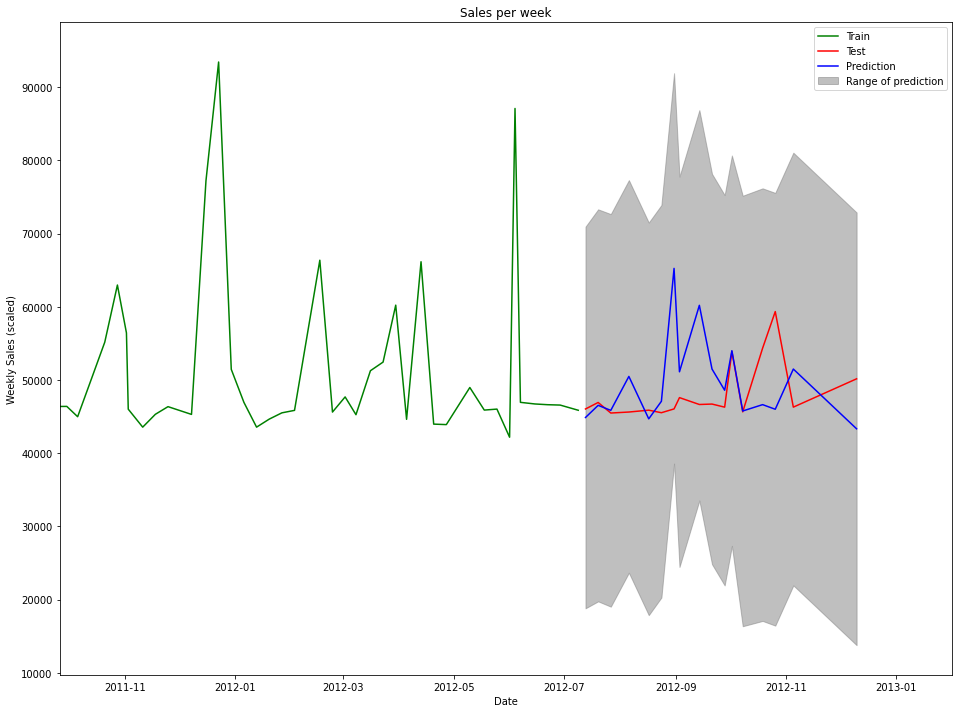

In [20]:
# Set up parameters
xlim = [datetime.date(2011, 9, 26), datetime.date(2013, 2, 1)]
pred_upper = y_pred_in_test['upper Weekly_Sales']
pred_lower = y_pred_in_test['lower Weekly_Sales']

# Call the plot_prediction function with the set parameters
plot_prediction(xlim, pred_lower, pred_upper, y_pred_out_test)

In [21]:
# Calculate the RMSE to evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_out_test))
print(f"RMSE: {rmse:.5f}")

RMSE: 0.74082


### Findings
The RMSE is around 0.74082. This is a pretty good score. This is also shown on the plot. The prediction don't differ a lot from the test set and are between the minimum and maximum.

In [22]:
# Instantiate and fit the model
model = SARIMAX(y_train, seasonal_order=(2,2,2,12))
model = model.fit()

# Predict on the test set and set index for in the future
index = pd.date_range(test.index[0], "2013-03-30", freq = 'W')
y_pred = model.get_forecast(len(index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 

# Predict based on the index of y_pred_df
y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])

# Set the index to that of the index defined earlier
y_pred_df.index = index

# Select the predictions and the lower and upper values seperately
y_pred_out_future = y_pred_df["Predictions"] 
y_pred_in_future = y_pred_df.drop('Predictions', axis = 1)

C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ardejong\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

C:\Users\ardejong\AppData\Local\Temp/ipykernel_19416/2460851066.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


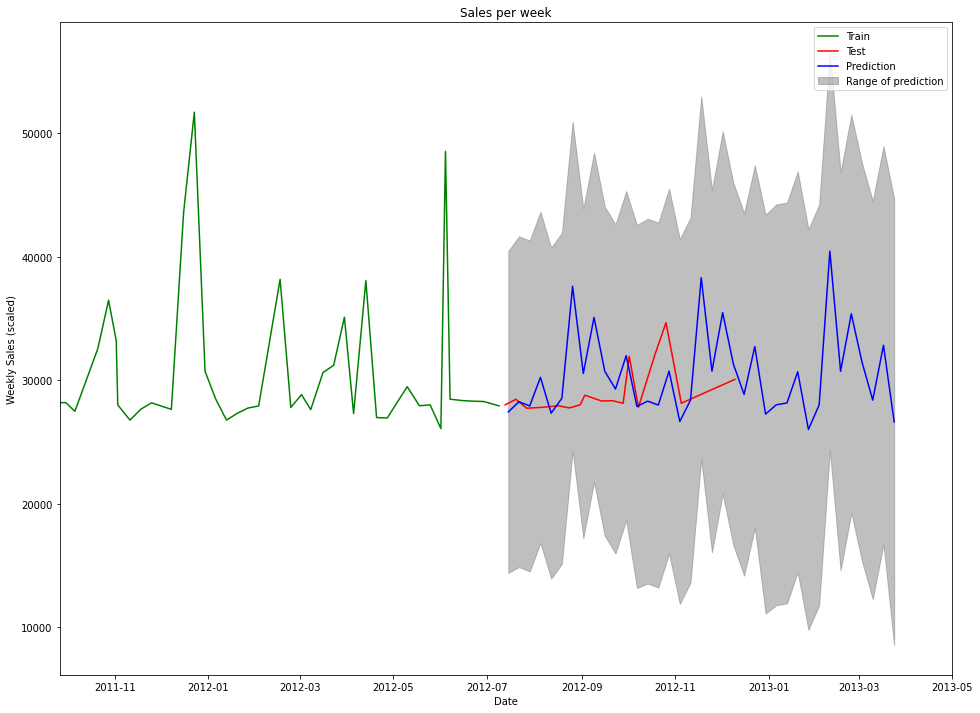

In [23]:
# Set up parameters
xlim = [datetime.date(2011, 9, 26), datetime.date(2013, 5, 1)]
pred_upper = y_pred_in_future['upper Weekly_Sales']
pred_lower = y_pred_in_future['lower Weekly_Sales']

# Call the plot_prediction function with the set parameters
plot_prediction(xlim, pred_lower, pred_upper, y_pred_out_future, index = index)

# Conclusions
Based on our analysis and predictions, it looks like that there're higher sales around the holidays. Also what we see from the visualizations is that around extreme temperatures (both hot and cold) the sales will be less than less extreme temperatures. 

Based on these two findings, I'd recommend to apply some discount on popular products around the holidays. I'd also recommend to apply discount on cooling/heating products around days of extreme temperatures so that customers are more likely to buy something in the store.